# Intro to Likelihood-free Inference using pytorch-lightning

### subMIT Workshop IAP 2024

#### Deep Chatterjee (deep1018@mit.edu), LIGO Lab & A3D3

- Brief background on likelihood-free inference
- Look at a simple problem - _Linear regression_
  - Infer slope and intercept of a line given noisy data
  - Work out the answer analytically
  - Do the same using stochastic sampling - MCMC/nested sampling
  - Do the same using posterior estimation via a normalizing flow using `pyro`
- Introduce `pytorch-lightning` and do the same problem using distributed training

# Background

# Inference

$$\text{We have a model}\;f(\mathbf{\Theta}) \rightarrow \text{Collect data}\;\mathbf{d} \rightarrow \text{infer signal parameters}\;\mathbf{\Theta}\;$$


- Terminology
  - **Signal**: True model i.e., data in absence of noise
  - **Data**: Signal + Noise
  - $\mathbf{d} = f(\mathbf{\Theta}) + n$
- _Noise_ in experiments causes measurement _uncertainties_

- Noise $\rightarrow$ probability distribution of data, $\mathbf{d}$ for the same parameters, $\mathbf{\Theta}$.

$$ \text{Likelihood}\;L \equiv p(\mathbf{d}\vert\mathbf{\Theta}) $$

- As noise $\rightarrow 0$, $L \rightarrow \delta[\mathbf{d} - f(\mathbf{\Theta})]$.
- In bayesian inference, we want the posterior,

$$p(\mathbf{\Theta}\vert\mathbf{d}) = \frac{p(\mathbf{d}\vert\mathbf{\Theta})\;p(\mathbf{\Theta})}{p(\mathbf{d})}$$

- Generally done using stochastic sampling techniques (MCMC, nested sampling)
  - Propose $\mathbf{\Theta}_i \sim p(\mathbf{\Theta})$
  - Generate signal $f(\mathbf{\Theta}_i)$
  - Compute likelihood $L_i \rightarrow$ Accept/Reject proposed point.
  - Repeat...

# Linear model

\begin{align}
y_i =  \underbrace{mx_i + c}_{\text{true model }f(x_i)} + \epsilon_i.
\end{align}

- We want to estimate slope and intercept, $\{m, c\}$
- Data is noisy. Assume $\epsilon \sim \mathcal{N}(0, \sigma^2)$.

# Likelihood

- The noise term, $\epsilon\sim \mathcal{N}(0, \sigma^2)$
\begin{align}
  L(\{y_i\} \vert m, c, \sigma)  &\propto \exp\left[-\frac{1}{2\sigma^2}\sum_i\left(y_i - mx_i - c\right)^2\right]
\end{align}

- Maximize the likelihood

\begin{align}
  \frac{\partial L}{\partial m} = \frac{\partial L}{\partial c} = 0
\end{align}

- Least square answer

\begin{align}
  \hat{m} = \frac{\sum x_iy_i}{\sum x_i^2}\;\;\;;\;\; \hat{c} = \frac{\sum y_i}{n}.
\end{align}



- Re-express likelihood around maximum $\{\hat{m},  \hat{c}\}$

\begin{align}
   L(\{y_i\} \vert m, c, \sigma) &\propto \exp{\left[-\frac{\sum x_i^2}{2\sigma^2}\left(m - \hat{m}\right)^2\right]} \times
  \exp{\left[-\frac{n}{2\sigma^2}\left(c - \hat{c}\right)^2\right]}.
\end{align}

- The likelihood is a gaussian around the least square values.
- Corresponding widths are $\Delta m \sim \left(\sigma/\sqrt{\sum x_i^2}\right)$ and $\Delta c \sim \left(\sigma/\sqrt{n}\right)$.


# Posterior

\begin{align}
p(m, c, \sigma \vert \{y_i\}) \propto L(\{y_i\} \vert m, c, \sigma)\;p(m)\;p(c)\;p(\sigma)
\end{align}

- Assume uninformative priors on parameters, $p(m)\;,\; p(c) \sim 1$.
- Assume $\sigma$ is known i.e. $p(\sigma') = \delta(\sigma - \sigma')$.
- The posterior is also a gaussian (same as the likelihood in this example).

## Marginals

\begin{align}
  p(m\vert \{y_i\}) &\propto 
  \int L(\{y_i\}\vert m, c, \sigma')\;\underbrace{p(m)\;p(c)}_{\sim 1}\;\overbrace{p(\sigma)}^{\sim \delta(\sigma - \sigma')} dc\;d\sigma' \\
  &\propto \exp{\left[-\frac{\sum x_i^2}{2\sigma^2}\left(m - \hat{m}\right)^2\right]}.
\end{align}

\begin{align}
  p(c\vert \{y_i\}) &\propto 
  \int L(\{y_i\}\vert m, c, \sigma')\;{p(m)\;p(c)}\;{p(\sigma)}\;dm\;d\sigma' \\
  &\propto \exp{\left[-\frac{n}{2\sigma^2}\left(c - \hat{c}\right)^2\right]}.
\end{align}

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def linear_model(x, m, c):
    return m*x + c

### Generate data with a linear correlation and noise

In [9]:
injection_parameters = dict(m=0.8, c=2)

In [64]:
np.random.seed(218)
num_points = 200
x = np.linspace(-4, 4, num_points)

In [65]:
sigma = 0.6

In [66]:
data = linear_model(x, **injection_parameters) + np.random.normal(0, sigma, x.size)

Text(0, 0.5, 'y')

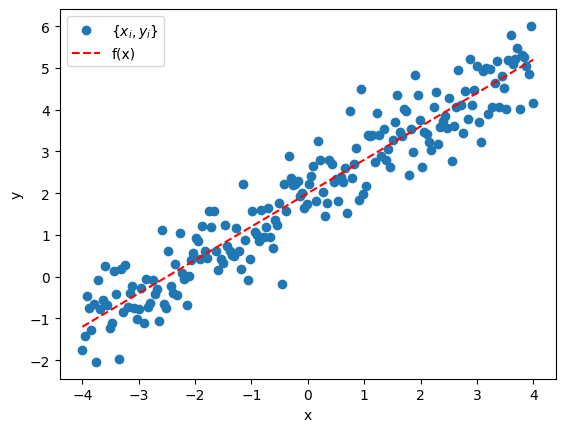

In [67]:
fig, ax = plt.subplots()
ax.plot(x, data, 'o', label='$\\{x_i, y_i\\}$')
ax.plot(x, linear_model(x, **injection_parameters), '--r', label='f(x)')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

In [68]:
m_hat = (x * data).sum() / (x * x).sum()
c_hat = data.sum() / num_points

delta_m = sigma/np.sqrt(np.sum((x)**2))
delta_c = sigma * np.sqrt(1/num_points)

print("Expected m = {:.3f} +/- {:.3f}".format(m_hat, delta_m))

Expected m = 0.798 +/- 0.018


In [69]:
print("Expected c = {:.3f} +/- {:.3f}".format(c_hat, delta_c))

Expected c = 1.987 +/- 0.042


In [70]:
import bilby
from bilby.core.likelihood import GaussianLikelihood
from bilby.core.prior import Uniform, DeltaFunction

In [71]:
priors = dict()

priors['m'] = Uniform(-3, 3, name='m', latex_label='m')
priors['c'] = Uniform(-3, 3, name='c', latex_label='c')

In [72]:
log_l = GaussianLikelihood(x, data, linear_model, sigma=sigma)

In [73]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    result = bilby.run_sampler(
        likelihood=log_l, priors=priors, sampler='dynesty',
        nlive=500, npool=4, save=False, clean=True,
        injection_parameters=injection_parameters,
        outdir='./linear_regression',
        label='linear_regression'
    )

14:50 bilby INFO    : Running for label 'linear_regression', output will be saved to './linear_regression'
14:50 bilby INFO    : Analysis priors:
14:50 bilby INFO    : m=Uniform(minimum=-3, maximum=3, name='m', latex_label='m', unit=None, boundary=None)
14:50 bilby INFO    : c=Uniform(minimum=-3, maximum=3, name='c', latex_label='c', unit=None, boundary=None)
14:50 bilby INFO    : Analysis likelihood class: <class 'bilby.core.likelihood.GaussianLikelihood'>
14:50 bilby INFO    : Analysis likelihood noise evidence: nan
14:50 bilby INFO    : Single likelihood evaluation took 9.378e-05 s
14:50 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 500, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'npdim': None, 'rstate': None, 'queue_size': 4, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'gradient': None, 'grad_args'

5606it [00:20, 355.73it/s, bound:123 nc:  1 ncall:9.6e+04 eff:6.3% logz=-187.96+/-0.13 dlogz:0.023>0.1]     

14:50 bilby INFO    : Written checkpoint file ./linear_regression/linear_regression_resume.pickle
14:51 bilby INFO    : Starting to close worker pool.
14:51 bilby INFO    : Finished closing worker pool.


5606it [00:28, 194.90it/s, bound:123 nc:  1 ncall:9.6e+04 eff:6.4% logz=-187.94+/-0.12 dlogz:0.000>0.1]

14:51 bilby INFO    : Rejection sampling nested samples to obtain 1320 posterior samples
14:51 bilby INFO    : Sampling time: 0:00:28.738421
14:51 bilby INFO    : Summary of results:
nsamples: 1320
ln_noise_evidence:    nan
ln_evidence: -187.941 +/-  0.156
ln_bayes_factor:    nan +/-  0.156



## Result from nested sampling

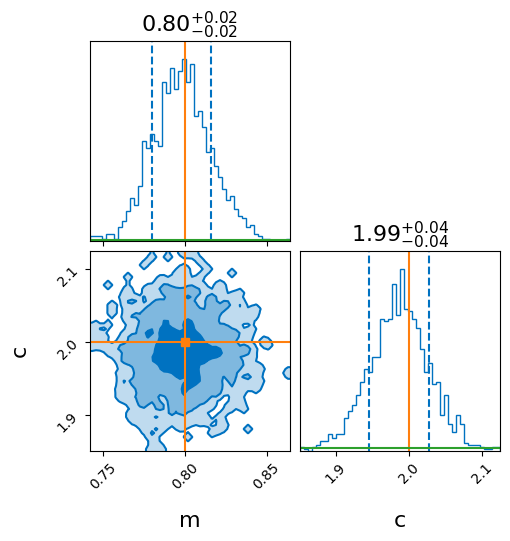

In [74]:
result.plot_corner(priors=True, quantiles=(0.16, 0.84))

# Repeating the same problem using likelihood-free inference
By posterior estimation using a normalizing flow

- We can simulate signals
  - Given $\mathbf{\Theta}_i \sim p(\mathbf{\Theta}) \rightarrow$ generate signal $f(\mathbf{\Theta}_i)$
  - Add instrument noise $f(\mathbf{\Theta}_i) + n \rightarrow \mathbf{d}_i$
- We can "easily" get pairs $\{\mathbf{\Theta}_i, \mathbf{d}_i\}$
- From $\{\mathbf{\Theta}_i, \mathbf{d}_i\} \rightarrow p(\mathbf{\Theta}, \mathbf{d}), p(\mathbf{\Theta}\vert \mathbf{d}), p(\mathbf{d}\vert\mathbf{\Theta})$
- Here, we are interested in the posterior estimation

- The distributions are complex
- A solution is to use a Normalizing flow
  - Contains a **learnable transform** (a trainable neural network)
  - A **base distribution** (often taken to be normal)
- Here we use a affine-autogressive transform from `pyro`
- A standard normal base distribution

In [75]:
from IPython.display import clear_output
from time import sleep

def live_plot_samples(samples, truth):
    clear_output(wait=True)
    sleep(1)
    figure = corner.corner(
        samples.numpy(), quantiles=[0.16, 0.5, 0.84],
        show_titles=True, labels=["m", "c"],
        truth=truth
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")


def live_plot_bilby_result(result, **kwargs):
    clear_output(wait=True)
    sleep(1)
    result.plot_corner(priors=True)

In [76]:
def get_data(m=None, c=None, num_points=1):
    """Sample m, c and return a batch of data with noise"""
    m = priors['m'].sample() if m is None else m
    c = priors['c'].sample() if c is None else c
    x = np.linspace(-4, 4, num_points)
    y = m*x + c
    y += sigma*np.random.normal(size=x.size)

    return x, y, m, c

# Generate simulations

In [77]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [78]:
from lightning import pytorch as pl

In [79]:
num_simulations = 40000
theta_vals = []
data_vals = []
for ii in range(num_simulations):
    x_val, y_val, m_val, c_val = get_data(num_points=num_points)
    data_vals.append(y_val)
    theta_vals.append([m_val, c_val])

In [80]:
theta_vals = torch.from_numpy(np.array(theta_vals)).to(torch.float32)
data_vals = torch.from_numpy(np.array(data_vals)).to(torch.float32)

In [81]:
class DataGenerator(Dataset):
    def __len__(self):
        return num_simulations

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return theta_vals[idx], data_vals[idx]

In [82]:
dataset = DataGenerator()

In [83]:
train_set_size = int(0.8 * num_simulations)
val_set_size = int(0.1 * num_simulations)
test_set_size = int(0.1 * num_simulations)

train_data, val_data, test_data = torch.utils.data.random_split(
    dataset, [train_set_size, val_set_size, test_set_size])

In [84]:
TRAIN_BATCH_SIZE = 40
TEST_BATCH_SIZE = 1
LR = 1e-3

In [85]:
import torch.distributions as dist

In [86]:
from pyro.nn import ConditionalAutoRegressiveNN
from pyro.distributions import ConditionalTransformedDistribution
from pyro.distributions.transforms import ConditionalAffineAutoregressive

# MADE in Pytorch Lightning

Quick recap of terminology
- **Dataset**: the entire dataset, tuples of $\{\mathbf{\Theta}_i, \mathbf{d}_i\}$
- **Dataloader**: partition of dataset into batches i.e. gives a batch of data
- **Training loop**: One epoch
  - Push a batch of data
  - Calculate loss
  - Compute all gradients
  - Change all weights based on gradients
  - Repeats until all batches are done

Pytorch-lightning removes boilerplate code
- `torch.nn.Module` $\rightarrow$ `pl.LightningModule`
- Provides methods: `training_step`, `validation_step`, `test_step`, `configure_optimizers`
- No need of explicit training loop
- Automatic checkpoints, several options for logging
- Easily scales to multi-GPU distributed training

In [87]:
import pandas as pd
import corner

def cast_as_bilby_result(samples, truth):
    injections = dict.fromkeys(injection_parameters)
    injections['m'] = float(truth.numpy()[0])
    injections['c'] = float(truth.numpy()[1])

    posterior = dict.fromkeys(injection_parameters)
    samples_numpy = samples.numpy()
    posterior['m'] = samples_numpy.T[0].flatten()
    posterior['c'] = samples_numpy.T[1].flatten()
    posterior = pd.DataFrame(posterior)
    
    return bilby.result.Result(
        label="test_data",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=list(injections.keys()),
        priors=priors
    )

In [88]:
class MADE(pl.LightningModule):
    def __init__(
        self,
        input_dim,
        context_dim,
        hidden_dim,
        learning_rate: float = LR,
        batch_size: int = TRAIN_BATCH_SIZE,
    ):
        super().__init__()
        self.base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim))
        self.hypernet = ConditionalAutoRegressiveNN(input_dim, context_dim, hidden_dims)
        self.transform = ConditionalAffineAutoregressive(self.hypernet)
        self.flow = ConditionalTransformedDistribution(self.base_dist, [self.transform])

        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def log_prob(self, theta, data):
        return self.flow.condition(data).log_prob(theta).mean()

    
    def training_step(self, batch, batch_idx):
        theta, data = batch
        loss = - self.log_prob(theta, data)
        self.log("train_loss", loss, on_step=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        theta, data = batch
        loss = - self.log_prob(theta, data)
        self.log("valid_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        theta, data = batch
        samples = self.flow.condition(data).sample([2000])
        res = cast_as_bilby_result(samples, theta[0])
        self.test_results.append(res)

    def configure_optimizers(self):
        parameters = self.transform.parameters()
        optimizer = torch.optim.AdamW(parameters, self.learning_rate)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            self.learning_rate,
            pct_start=0.1,
            total_steps=self.trainer.estimated_stepping_batches
        )
        scheduler_config = dict(scheduler=scheduler, interval="step")
        return dict(optimizer=optimizer, lr_scheduler=scheduler_config)
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            train_data,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            val_data,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            test_data,
            batch_size=1,
            shuffle=False,
            pin_memory=True
        )

In [89]:
class PPPlotCallback(pl.Callback):
    def on_test_start(self, trainer, pl_module):
        pl_module.test_results = []

    def on_test_end(self, trainer, pl_module):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            bilby.result.make_pp_plot(pl_module.test_results, save=False, keys=['m', 'c'])
        pl_module.test_results.clear()

In [90]:
input_dim = 2
context_dim = num_points
hidden_dims = [5*input_dim, 5*input_dim]

model = MADE(input_dim, context_dim, hidden_dims, batch_size=40, learning_rate=5e-3)

trainer = pl.Trainer(
    max_epochs=20,
    log_every_n_steps=100,
    logger=pl.loggers.CSVLogger("logs", name="made-expt"),
    callbacks=[PPPlotCallback()]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [91]:
%%capture
trainer.fit(model)

Missing logger folder: logs/made-expt
Loading `train_dataloader` to estimate number of stepping batches.

  | Name      | Type                            | Params
--------------------------------------------------------------
0 | hypernet  | ConditionalAutoRegressiveNN     | 2.2 K 
1 | transform | ConditionalAffineAutoregressive | 2.2 K 
--------------------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=20` reached.


# Example posteriors

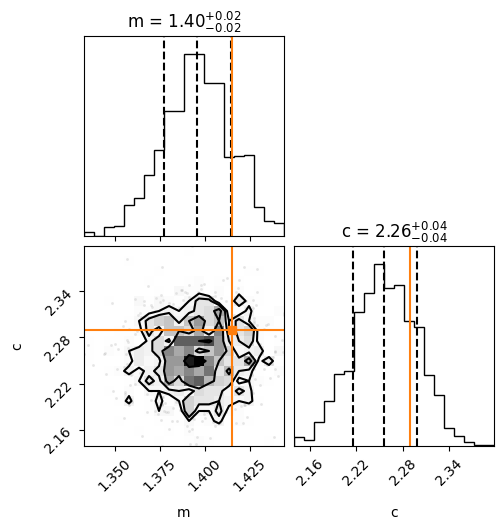

In [92]:
for idx, (theta_test, data_test) in enumerate(test_data):
    if idx == 5: break 
    with torch.no_grad():
        samples = model.flow.condition(data_test).sample([1000])
    live_plot_samples(samples, theta_test)
    plt.show()

/work/submit/xuejian/miniforge3/envs/pytorch/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 4000/4000 [00:16<00:00, 246.87it/s]

14:56 bilby INFO    : Key: KS-test p-value
14:56 bilby INFO    : m: 0.15886118776783908
14:56 bilby INFO    : c: 0.1957052812262534
14:56 bilby INFO    : Combined p-value: 0.1389992266893983


Testing DataLoader 0: 100%|██████████| 4000/4000 [00:29<00:00, 135.50it/s]


[{}]

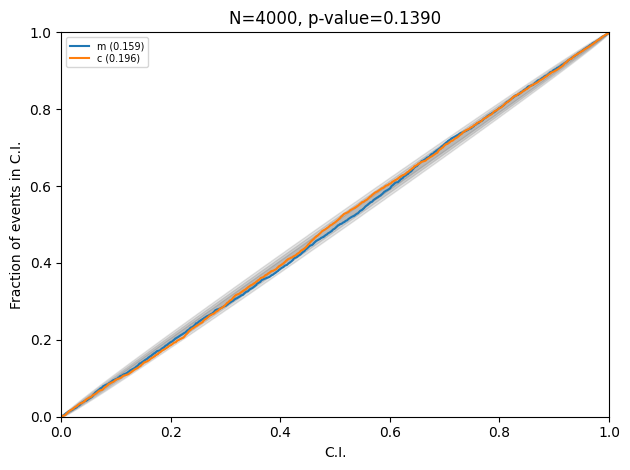

In [93]:
trainer.test(model)

## Result from normalizing flow

In [94]:
with torch.no_grad():
    flow_samples = model.flow.condition(
        torch.from_numpy(data).unsqueeze(0).to(dtype=torch.float32)
    ).sample([1000])
truth = np.array(list(injection_parameters.values()))

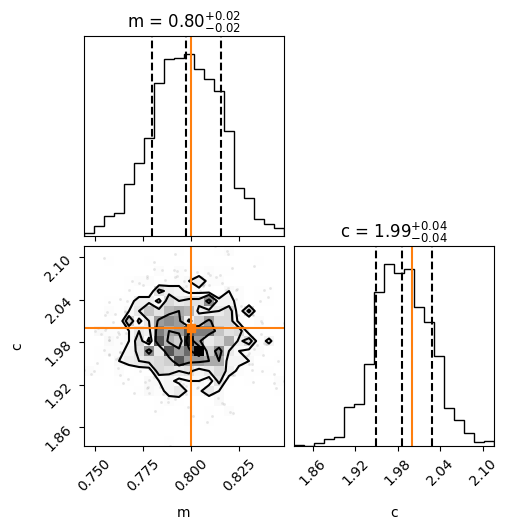

In [95]:
live_plot_samples(flow_samples, truth)